In [1]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from datetime import datetime

import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm
import sqlite3

conn = sqlite3.connect("../data/tracking.db")
c = conn.cursor()

In [2]:
SOURCE_VIDEO_PATH = "../data/processed/Wildtrack_dataset/Image_subsets/C1"
ANNOTATIONS_FOLDER = "../data/processed/Wildtrack_dataset/annotations_positions"

PERSON_DETECTION_MODEL = YOLO("../models/yolo11m.pt")
PERSON_ID = 0

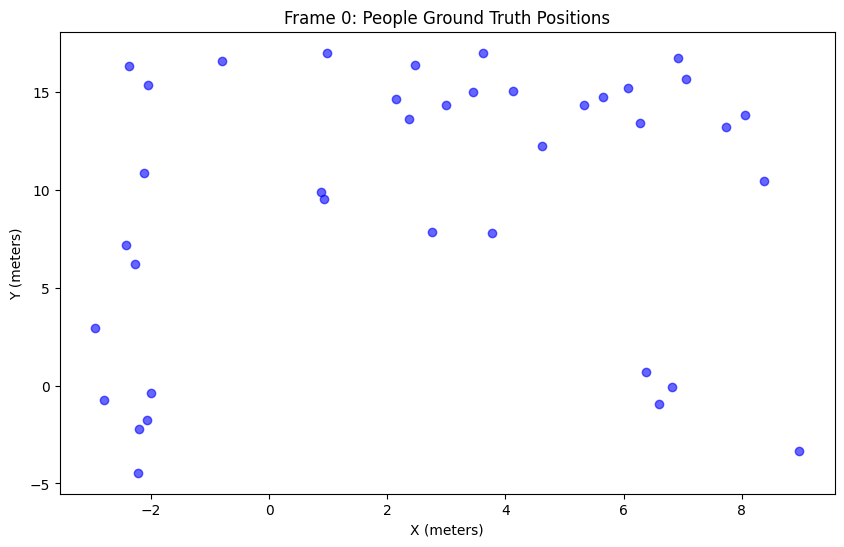

In [3]:
GRID_SPACING = 0.025
GRID_ORIGIN_X = -3.0
GRID_ORIGIN_Y = -9.0

def position_id_to_xy(position_id):
    x = GRID_ORIGIN_X + GRID_SPACING * (position_id % 480)
    y = GRID_ORIGIN_Y + GRID_SPACING * (position_id // 480)
    return x, y

def load_frame_positions(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    positions = [position_id_to_xy(person['positionID']) for person in data]
    return positions

frame_files = sorted(os.listdir(ANNOTATIONS_FOLDER))
max_frames = 50
if max_frames:
    frame_files = frame_files[:max_frames]

plt.figure(figsize=(10, 6))
for i, file_name in enumerate(frame_files):
    positions = load_frame_positions(os.path.join(ANNOTATIONS_FOLDER, file_name))
    xs, ys = zip(*positions)
    plt.cla()
    plt.scatter(xs, ys, c='blue', label=f'Frame {i}', alpha=0.6)
    plt.title(f"Frame {i}: People Ground Truth Positions")
    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    # plt.xlim(-3, 9)   # dataset extent
    # plt.ylim(-9, 27)
    plt.pause(0.1)
    break

plt.show()


In [4]:
results = PERSON_DETECTION_MODEL.track(
    SOURCE_VIDEO_PATH, 
    show=True, conf=0.3, tracker="botsort.yaml", 
    #persist=True,
    stream=True,
)

2025-06-03 14:39:20.095 Python[74156:9256915] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/kg/87d0nmxn11xbzs39mwh7hjvr0000gn/T/org.python.python.savedState


In [5]:
track_seen = set()

for i,r in enumerate(results):
    if 10 <= i:
        break
    # Timestamp for current frame
    ts = datetime.now()

    if r.boxes.id is None:
        continue  # No tracking IDs yet

    for box, track_id in zip(r.boxes.xyxy, r.boxes.id):
        x1, y1, x2, y2 = box.tolist()
        cx, cy = (x1 + x2) / 2, (y1 + y2) / 2  # center point in image space

        # Optionally: project cx, cy to floor plane using cv2.perspectiveTransform()

        track_id = int(track_id)

        # Add new person to people_tracks
        if track_id not in track_seen:
            c.execute('''
                INSERT OR IGNORE INTO people_tracks (id, first_seen, last_seen)
                VALUES (?, ?, ?)
            ''', (track_id, ts, ts))
            track_seen.add(track_id)
        else:
            c.execute('''
                UPDATE people_tracks SET last_seen = ? WHERE id = ?
            ''', (ts, track_id))

        # Insert position record
        c.execute('''
            INSERT INTO positions (track_id, timestamp, x, y)
            VALUES (?, ?, ?, ?)
        ''', (track_id, ts, cx, cy))

    conn.commit()


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


image 1/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000000.png: 384x640 15 persons, 1 truck, 2 backpacks, 2 handbags, 697.8ms
image 2/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000005.png: 384x640 17 persons, 2 backpacks, 539.1ms
image 3/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000010.png: 384x640 18 persons, 1 backpack, 525.3ms
image 4/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000015.png: 384x640 17 persons, 1 truck, 2 backpacks, 521.5ms
image 5/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000020.png: 384x640 19 person

In [ ]:
def read_intrinsics(file_path):
    fs = cv2.FileStorage(file_path, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def read_extrinsics(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Extract rvec and tvec
    rvec_element = root.find('rvec')
    tvec_element = root.find('tvec')
    
    if rvec_element is None or tvec_element is None:
        raise ValueError("Could not find rvec or tvec in XML file")
    
    # Convert text to numpy arrays
    rvec = np.fromstring(rvec_element.text.strip(), sep=' ')
    tvec = np.fromstring(tvec_element.text.strip(), sep=' ')

    # Convert rotation vector to rotation matrix
    R, _ = cv2.Rodrigues(rvec)
    return R, tvec


In [ ]:
# def backproject_to_ground(u, v, K, R, t):
#     """
#     Projects image point (u,v) to the ground plane Z=0 in world coordinates.
#     """
#     # Inverse camera intrinsics
#     K_inv = np.linalg.inv(K)

#     # Get normalized image coordinates
#     uv1 = np.array([u, v, 1.0])
#     ray_camera = K_inv @ uv1  # shape (3,)

#     # Transform ray to world coordinates
#     ray_world = R.T @ ray_camera
#     cam_center_world = -R.T @ t

#     # Plane Z=0: solve for intersection
#     scale = -cam_center_world[2] / ray_world[2]
#     world_point = cam_center_world + scale * ray_world

#     return world_point[:2]  # X, Y


# def backproject_to_ground(u, v, K, R, t):
#     # Step 1: back-project to camera coordinates
#     uv1 = np.array([u, v, 1.0])
#     ray_camera = np.linalg.inv(K) @ uv1

#     # Step 2: transform ray to world coordinates
#     ray_world = R.T @ ray_camera          # direction vector in world coords
#     cam_center_world = -R.T @ t.flatten() # camera origin in world coords

#     # Step 3: intersect ray with ground plane (Z=0)
#     scale = -cam_center_world[2] / ray_world[2]
#     point_world = cam_center_world + scale * ray_world

#     return point_world[:2]  # only X, Y needed for 2D map

def backproject_to_ground(x, y, K, R, t):
    """
    Projects a 2D image point onto the ground plane (Z=0) in world coordinates.
    
    Args:
        xy_img: [x, y] in image pixels
        K: Intrinsic matrix (3x3)
        R: Rotation matrix (3x3)
        t: Translation vector (3x1 or shape (3,))
    
    Returns:
        (X, Y) point in world coordinates on the ground plane (Z=0)
    """
    # Convert image pixel to normalized camera coordinates
    # x, y = xy_img
    uv1 = np.array([x, y, 1.0])
    cam_ray = np.linalg.inv(K) @ uv1  # Ray in camera coordinates

    # Convert to world coordinates
    # Ray equation in world frame: X = C + λ*d
    # C = camera center in world = -R.T @ t
    # d = direction in world = R.T @ cam_ray
    cam_center = -R.T @ t
    direction = R.T @ cam_ray

    # Intersect with ground plane Z=0
    # Solve: cam_center[2] + λ * direction[2] = 0
    λ = -cam_center[2] / direction[2]
    world_point = cam_center + λ * direction
    return world_point[:2]  # return X, Y


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


image 1/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000000.png: 384x640 15 persons, 1 truck, 2 backpacks, 2 handbags, 691.1ms


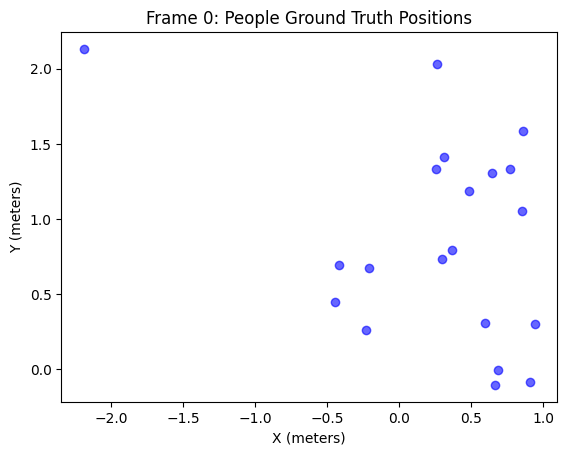

image 2/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000005.png: 384x640 6 persons, 522.6ms


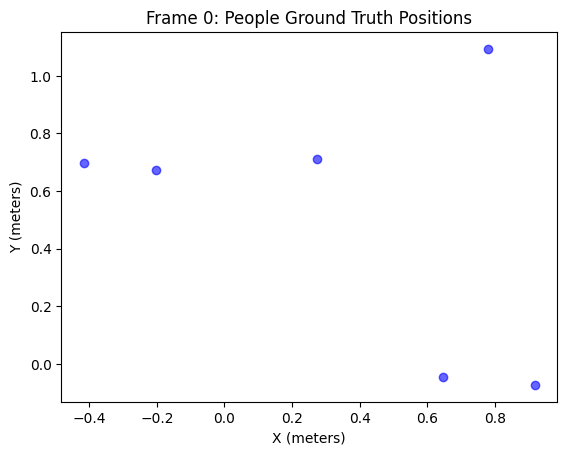

image 3/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000010.png: 384x640 5 persons, 521.2ms


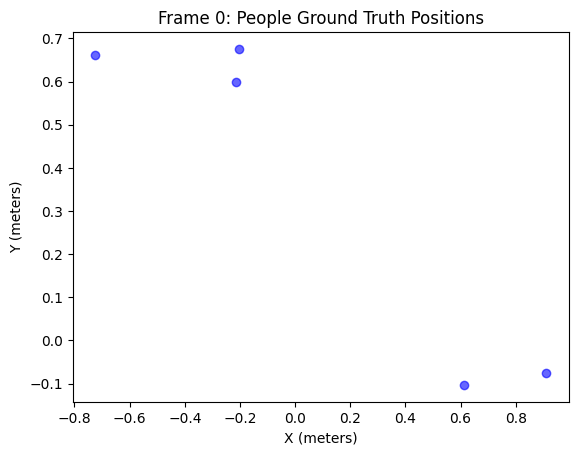

image 4/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000015.png: 384x640 9 persons, 1 truck, 510.1ms


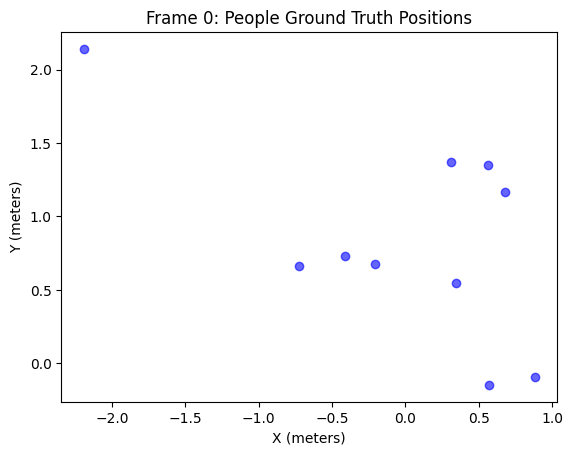

image 5/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000020.png: 384x640 6 persons, 1 truck, 518.3ms


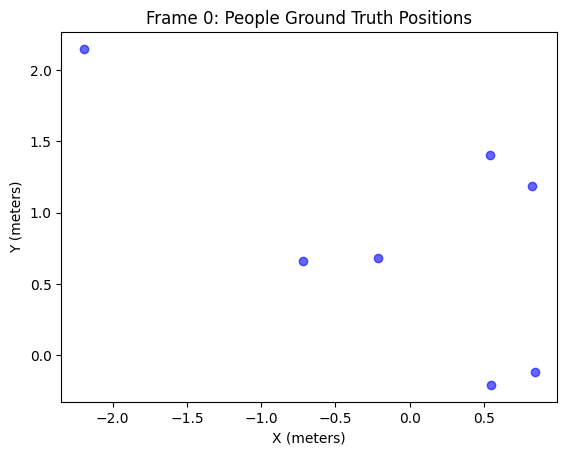

image 6/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000025.png: 384x640 6 persons, 1 truck, 511.9ms


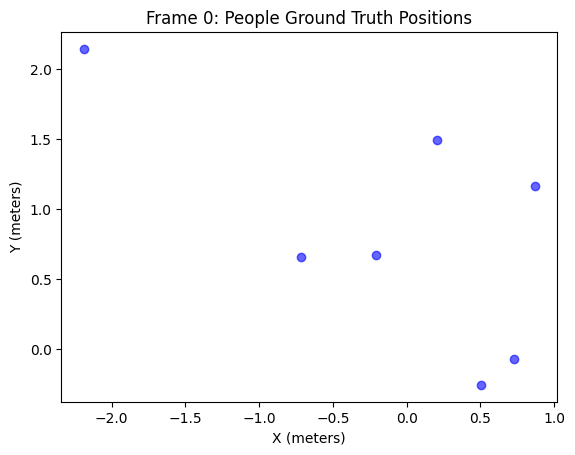

image 7/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000030.png: 384x640 10 persons, 1 truck, 524.1ms


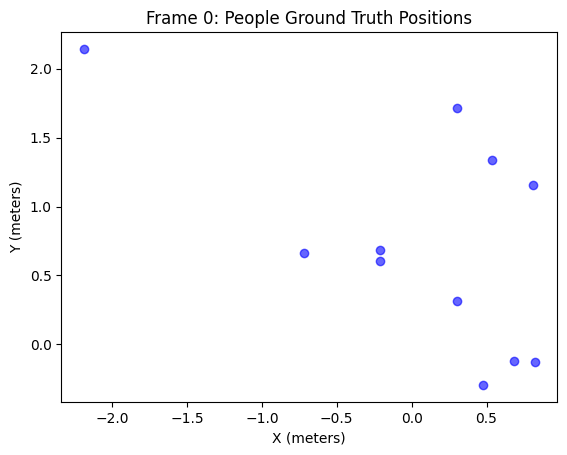

image 8/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000035.png: 384x640 9 persons, 514.9ms


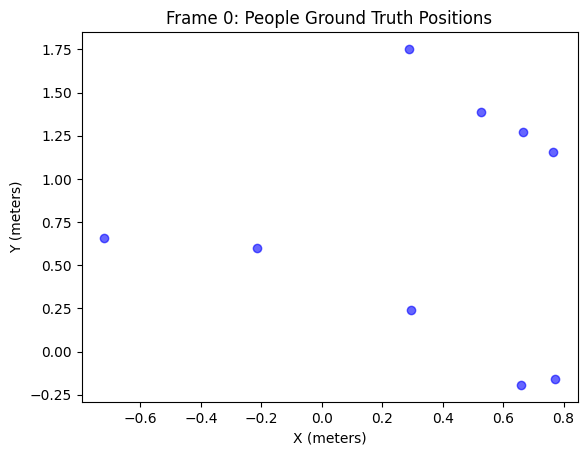

image 9/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000040.png: 384x640 7 persons, 514.7ms


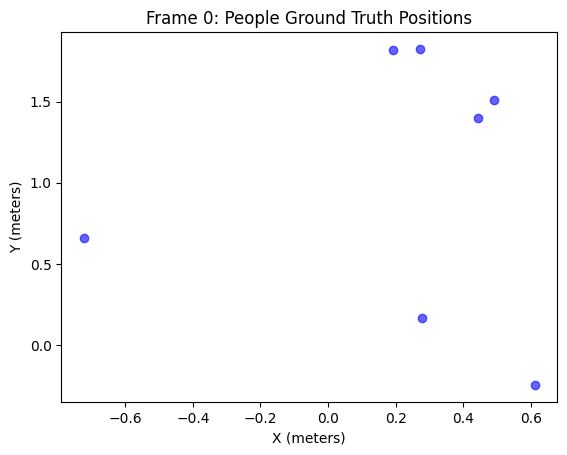

image 10/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000045.png: 384x640 10 persons, 1 handbag, 503.5ms


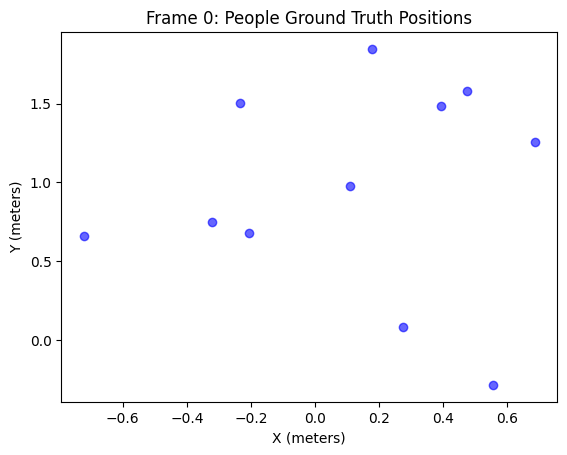

image 11/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000050.png: 384x640 12 persons, 1 backpack, 1 handbag, 517.2ms


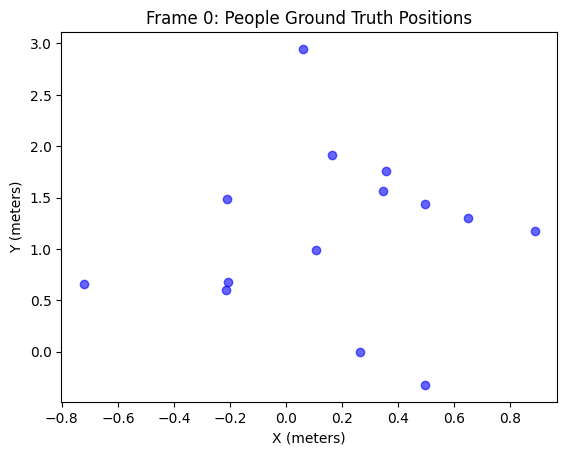

image 12/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000055.png: 384x640 8 persons, 1 handbag, 507.4ms


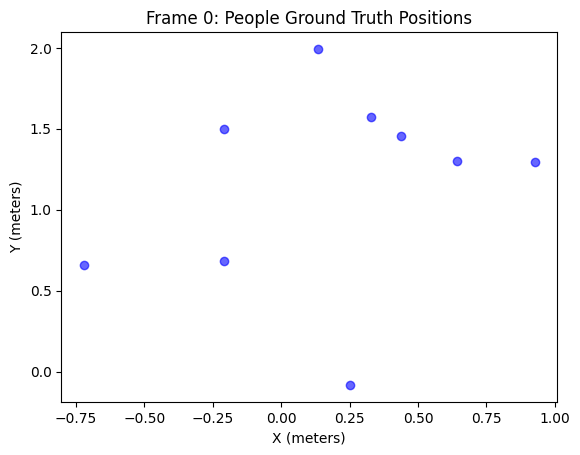

image 13/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000060.png: 384x640 9 persons, 487.6ms


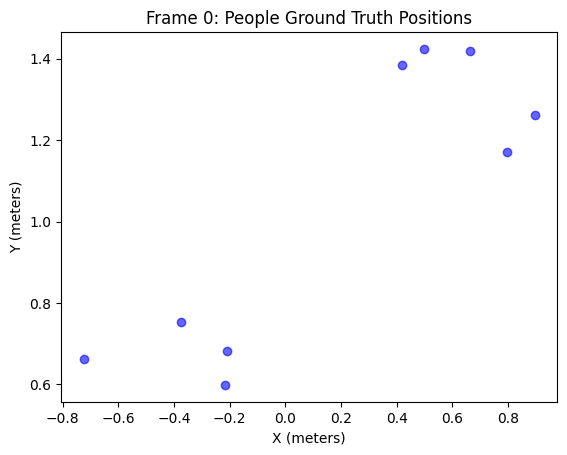

image 14/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000065.png: 384x640 12 persons, 1 truck, 507.0ms


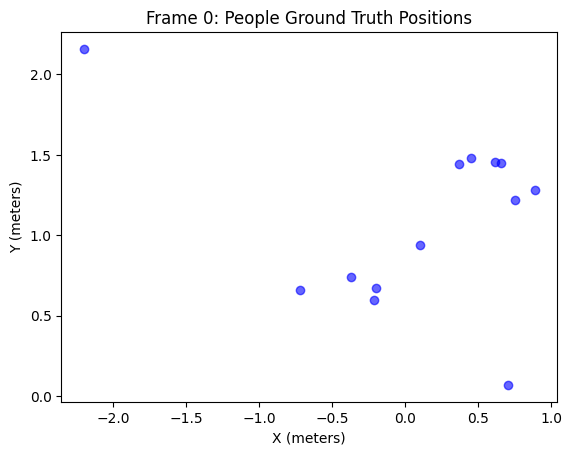

image 15/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000070.png: 384x640 13 persons, 491.4ms


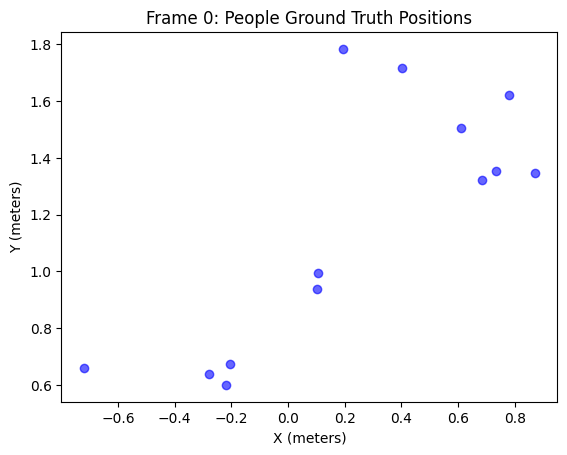

image 16/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000075.png: 384x640 13 persons, 1 handbag, 521.8ms


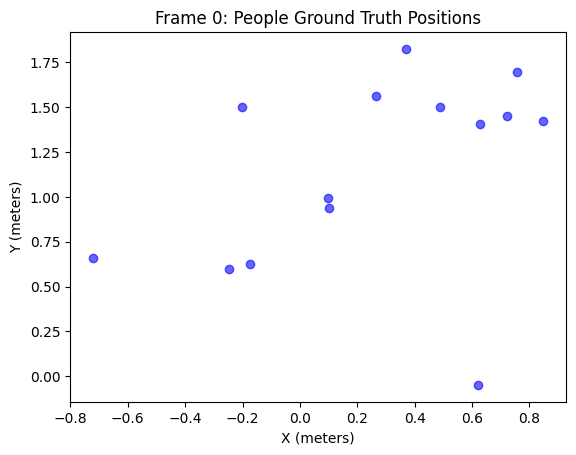

image 17/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000080.png: 384x640 14 persons, 1 handbag, 511.0ms


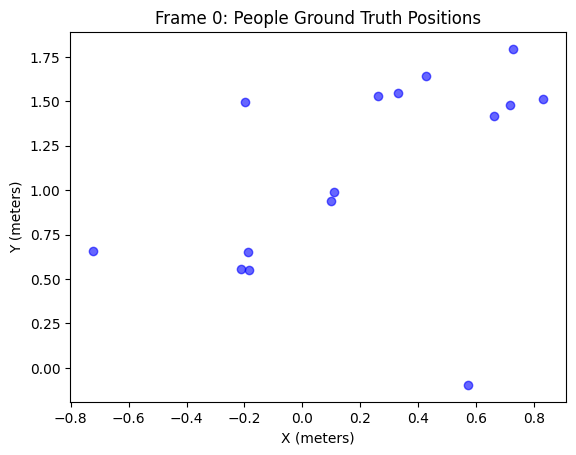

image 18/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000085.png: 384x640 11 persons, 1 handbag, 618.9ms


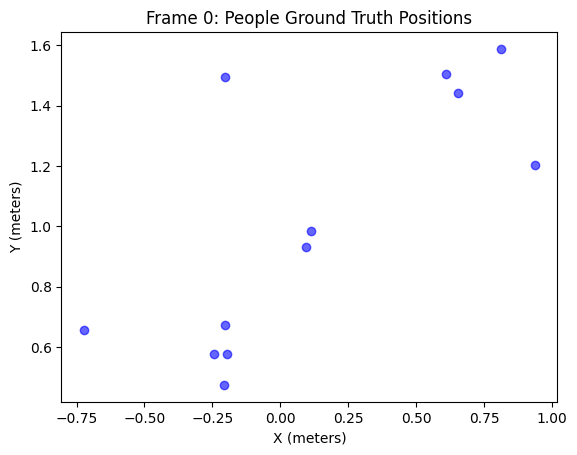

image 19/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000090.png: 384x640 11 persons, 1 handbag, 521.2ms


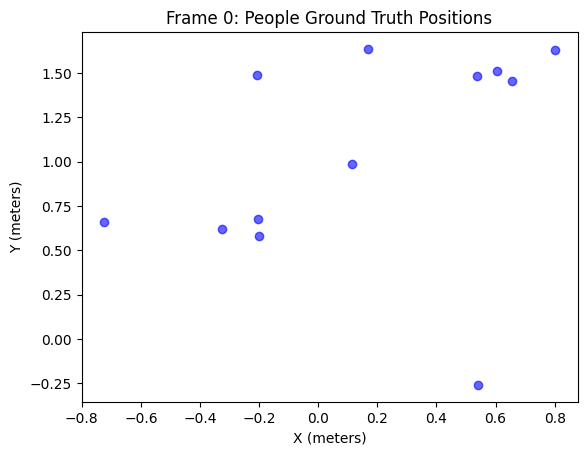

image 20/401 /Users/sebastianbitsch/Documents/Programmeringsprojekter/digitaltwin/notebooks/../data/processed/Wildtrack_dataset/Image_subsets/C1/00000095.png: 384x640 12 persons, 1 handbag, 507.2ms


KeyboardInterrupt: 

In [ ]:
# Load camera params (intrinsics and extrinsics)
K, dist = read_intrinsics("../data/processed/Wildtrack_dataset/calibrations/intrinsic_zero/intr_CVLab1.xml")
R, t = read_extrinsics("../data/processed/Wildtrack_dataset/calibrations/extrinsic/extr_CVLab1.xml")

# For each detection:
all_positions = []
for r in results:
    positions = []
    for det in r.boxes:
        xmin, ymin, xmax, ymax = det.xyxy[0].cpu().numpy()
        u = (xmin + xmax) / 2
        v = ymax

        X, Y = backproject_to_ground(u, v, K, R, t / 1000.0)
        # print(f"Person detected at ground plane: X={X:.2f}, Y={Y:.2f}")
        positions.append((X,Y))

    all_positions.append(positions)
    # break

    xs, ys = zip(*positions)
    plt.cla()
    plt.scatter(xs, ys, c='blue', label=f'Frame {i}', alpha=0.6)
    plt.title(f"Frame {i}: People Ground Truth Positions")
    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    # plt.xlim(-3, 9)   # dataset extent
    # plt.ylim(-9, 27)
    plt.pause(0.1)
    plt.show()